**This notebook analyses the performance of Multinolmial Naïve Bayes, Bernoulli Naïve BAyes and Linear SVC for sentiment analyses.** 

**Tokenizer : spacy's tokenizer and sikit learn's default tokenizer**
**Vectorizer : Sikit learn's CountVectorizer and TfidfVectorizer **

**Student Name : Harshita Asnani**

**Subject Name : IST 736 Text Mining**

**University : Syracuse University**

**Professor : Prof Yingya Li**


## Libraries 

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Data Extraction 

In [2]:
df = pd.read_csv("drugsComTrain_raw.csv")

In [3]:
df.head(2)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192


## Data  Preprocessing

In [4]:
df.nunique()

uniqueID       161297
drugName         3436
condition         884
review         112329
rating             10
date             3579
usefulCount       389
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
uniqueID       161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null int64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


We can notice from the information above that we have null values in only condition column. 

In [6]:
sum(df.isnull()['condition'])/len(df)

0.005573569254232875

In [7]:
#Since the totol number of rows with null values are less than 1% perct, we will drop those rows
df.dropna(inplace=True)
df.reset_index(inplace=True)

#### Top 20 conditions with the total number of drugs exists in the dataset

In [8]:
conditionGroupDF = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
conditionGroupDF[:20]

condition
Not Listed / Othe                             214
Pain                                          200
Birth Control                                 172
High Blood Pressure                           140
Acne                                          117
Depression                                    105
Rheumatoid Arthritis                           98
Diabetes, Type 2                               89
Allergic Rhinitis                              88
Bipolar Disorde                                80
Osteoarthritis                                 80
Insomnia                                       78
Anxiety                                        78
Abnormal Uterine Bleeding                      74
Migraine                                       59
Psoriasis                                      58
Endometriosis                                  57
3</span> users found this comment helpful.     57
ADHD                                           55
Asthma, Maintenance                     

As we can see in the above information, we got few of the condition with "user found this comment usefull". And also there is a sequence of number in the beginning of this conditions. We will try to find all of those and will remove them since without an specific condition mentioned,evaluating them towards the drug and reviews will not be useful.

The first label on x-axis is names as not listed/others and it has highest count of different drug bought. For the time being we will replace those with "others".

#### Removing rows which contains the unwanted information in condition column

In [9]:
len(df[df["condition"].str.contains("found",na=False)]['condition'])

900

In [10]:
x = df[df["condition"].str.contains("found",na=False)].index
df.drop(df.index[x],inplace=True)

#### Replacing the content of all cells which have their condition as "Not Listed/ Others" to "Others"

In [11]:
df[df["condition"].str.contains("Listed",na=False)].head(2)

,index,uniqueID,drugName,condition,review,rating,date,usefulCount
708,711,88150,Clindamycin,Not Listed / Othe,"""Just an FYI to all on this medication. Diarrh...",8,2-Nov-13,5
1519,1530,176731,Lorazepam,Not Listed / Othe,"""For severe panic attacks, the only medication...",7,30-Aug-08,8


In [12]:
indexes = df[df["condition"].str.contains("Listed",na=False)].index
df.loc[indexes,'condition'] = "Others"

### Converting 10 point Likerts scale to 3 point scale for negative, neutral and positive class
We will using https://www.ibm.com/support/pages/node/422073 article by IBM and formula given in the article to convert the scales.

The formula says: Y = (B-A)* (x-a)/(b-a)+A
<p>Where a,b are the min and max of the scale to be converted, in our case a=1 and b=10
    
A,B are the min and max of the scale to be converted into, in our case A=1 and B=3</p>

In [13]:
A=1
B=3
a=1
b=10

df['sentiment'] = ((B-A)*(df['rating']-a)/(b-a)+A).astype(int)

### Dropping unnecessary columns
Since the index column is unnecessary and was added automatically when we tried to reset the index after dropping nas. Also, unique id doesn't contribute anything towards the analysis since the unique are just used to represent each row uniquely

In [14]:
df.drop(['index','uniqueID'],inplace=True,axis=1)

## Exploratory Data Analysis

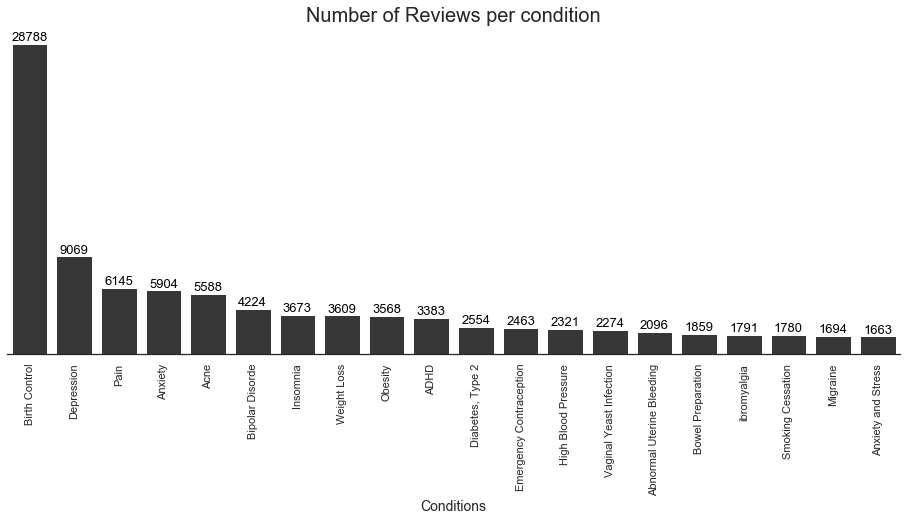

In [15]:
conditionDF = pd.DataFrame(df.groupby(['condition']).count().sort_values(by='usefulCount',ascending=False)['usefulCount'])[:20].reset_index()

plt.figure(figsize=(16,6))
sns.set(style="white")
g= sns.barplot(x="condition",y="usefulCount",data=conditionDF,color=(0.21569, 0.21569 ,0.21569))

g.set_xticklabels(rotation=90,labels=conditionDF['condition'])
g.set(yticklabels=[])
g.set_ylabel('')
g.axes.set_title("Number of Reviews per condition",fontsize=20)
g.set_xlabel('Conditions',fontsize=14)
sns.despine(left=True)

locs, labels = plt.xticks() # get the current tick locations and labels

for loc, label in zip(locs, labels):
    count = conditionDF.iloc[loc].usefulCount
    plt.text(loc, count-8, '{:0.0f}'.format(count), ha='center', va='bottom' ,color = 'black',size=13)

In [16]:
conditionDF.head()

,condition,usefulCount
0,Birth Control,28788
1,Depression,9069
2,Pain,6145
3,Anxiety,5904
4,Acne,5588


From the above plot, condition "Birth Control" contains the highest number of reviews which is about 18% of the data followed by "Depression" approx 5% and "Pain" approx 3%.

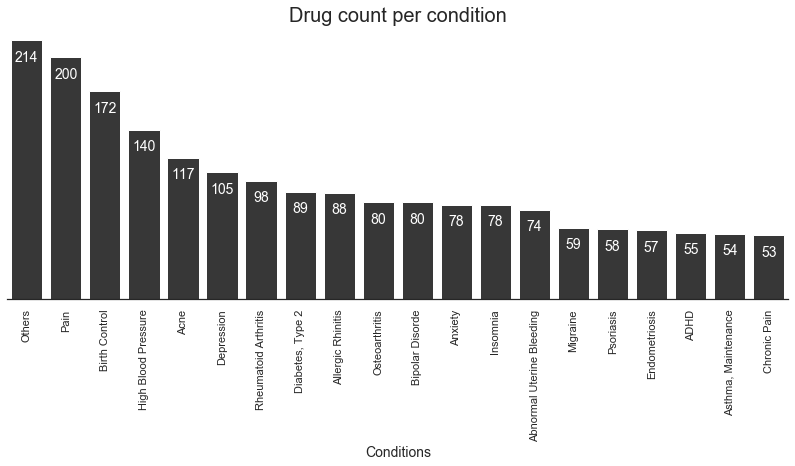

In [17]:
conditionGroupDF = pd.DataFrame(df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)[:20]).reset_index()

plt.figure(figsize=(14,5))
sns.set(style="white")

g = sns.barplot(y=conditionGroupDF['drugName'],x=conditionGroupDF['condition'],color=(0.21569, 0.21569 ,0.21569))

g.set_xticklabels(rotation=90,labels=conditionGroupDF['condition'])
g.set(yticklabels=[])
g.set_ylabel('')
g.axes.set_title("Drug count per condition",fontsize=20)
g.set_xlabel('Conditions',fontsize=14)
sns.despine(left=True)

locs, labels = plt.xticks() # get the current tick locations and labels

for loc, label in zip(locs, labels):
    count = conditionGroupDF.iloc[loc].drugName
    plt.text(loc, count-8, '{:0.0f}'.format(count), ha = 'center',va='top', color = 'w',size=14)

The above plot gives us the information about the number of different drugs available for each of the condition mentioned. We have plotted the top 20 condition in the decreasing order of their drugs count. The condition mentioned as "others" have the highest number of drugs available, it is since the specific condition isn't mentioned in this case. The second highest is the "Pain", it has 200 alternate drugs available. Painkillers drugs are widely sold drugs since they are used in all cases irrespective of age, gender and the critical conditions. The third most number of alternate drugs available are for the condition "Birth Control". According to wikipedia, in the United States 98% of sexually active women have used birth control at some point in time, and 62% of those of reproductive age are currently using birth control.

The later condition in the series also makes sense in real world, since blood pressure, acne, ADHD, depression, anxiety, insomnia are some of the common health condition and whose prescription people take without consulting a doctor. These condition are some of the most common causes in the world and there are thousands of alterative drugs available worldwide.

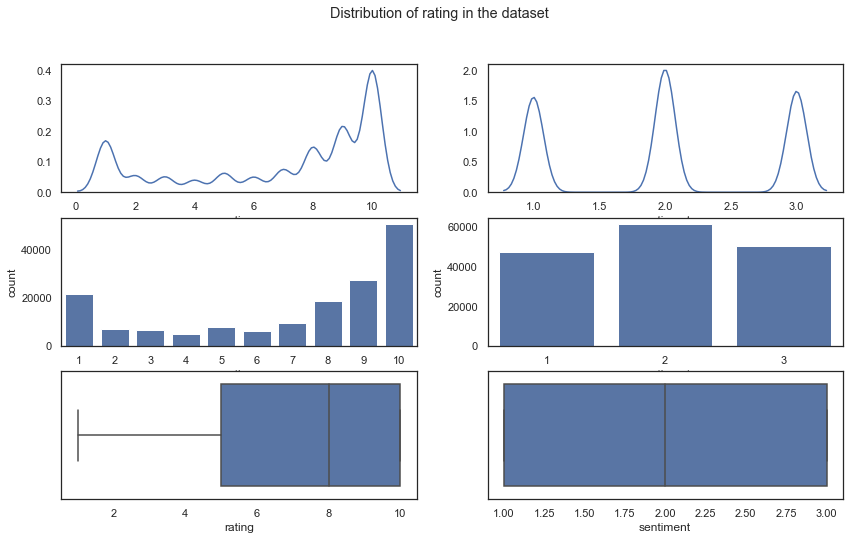

In [18]:
f, axes = plt.subplots(3, 2,figsize=(14, 8))
sns.countplot(df['rating'],color=sns.color_palette()[0],ax=axes[1][0])
sns.distplot(df['rating'], hist=False,ax=axes[0][0])
sns.boxplot(df['rating'],ax=axes[2][0])
g.set_ylabel('Count',fontsize=12)
plt.suptitle("Distribution of rating in the dataset");

sns.countplot(df['sentiment'],color=sns.color_palette()[0],ax=axes[1][1])
sns.distplot(df['sentiment'], hist=False,ax=axes[0][1])
sns.boxplot(df['sentiment'],ax=axes[2][1])

From the plot, we have more than 50,000 reviews from the group of "rating 10" followed by "rating 9" with 27219 count. "rating 1" group is the contains the third most count with 21391. Rating group from 2 - 7 contains less than 10,000 reviews count. Also from box plot, we can notice that 50% of the data lies between 8 to 10 since the median of the plot is at 8 and the third quartile and max are at 10. The data is right skewed.

But after converting 10-point likerts scale into 3 point scale fro extracting the positve, neutral and negative reviews. The data is approximately normal without any skewness. 

In [19]:
xDate =[]
xMonth = []
xYear = []
for x in df['date']:
    t = x.split("\n")[0]
    xDate.append(t)
    xMonth.append(datetime.strptime(t, '%d-%b-%y').month)
    xYear.append(datetime.strptime(t, '%d-%b-%y').year)
df['date'] = xDate
df['month'] = xMonth
df['year'] = xYear

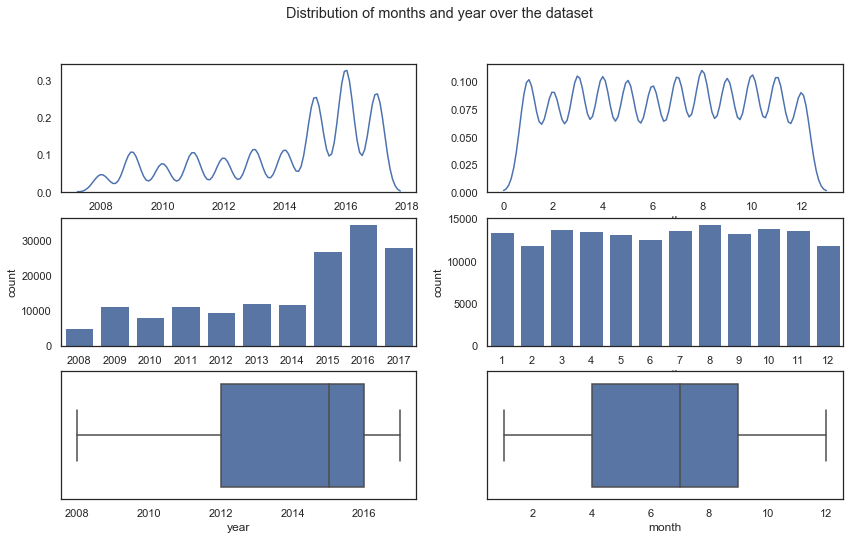

In [20]:
f, axes = plt.subplots(3, 2,figsize=(14, 8))
sns.countplot(df['year'],color=sns.color_palette()[0],ax=axes[1][0])
sns.distplot(df['year'],hist=False,color=sns.color_palette()[0],ax=axes[0][0])
sns.boxplot(df['year'],ax=axes[2][0])

sns.countplot(df['month'],color=sns.color_palette()[0],ax=axes[1][1])
sns.distplot(df['month'],hist=False,color=sns.color_palette()[0],ax=axes[0][1])
sns.boxplot(df['month'],ax=axes[2][1])

plt.suptitle("Distribution of months and year over the dataset");

The above plots shows the distribution of months and year over the dataset. As we see, more reviews have been collected in the later year after 2014. In 2016, maximum number of reviews was collected more than 30000 while both 2015 and 2016 share approximately same number of reviews with count around 28000. Also from the box plot, it shows that 50% of the data lies between 2012 to 2016 with median at 2015. 25% of the data lies between 2015 and 2016 only. 

When we tried to see the distribution of reviews over the months, we were not able to extract much information since the dataset is evenly distributed over the 12 months. 

In [21]:
#f,ax = plt.subplots(1,2,figsize=(14, 7))
#sns.jointplot(x ='rating', y ='year', data = df, kind ='kde',height=3,ax=ax[0],ratio=4)
#sns.jointplot(x ='rating', y ='year', data = df, kind ='kde',height=3,ratio=4,ax=ax[1])

In [22]:
df.head()

,drugName,condition,review,rating,date,usefulCount,sentiment,month,year
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2,5,2012
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,2,4,2010
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1,12,2009
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,2,11,2015
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2,11,2016


In [23]:
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize 

Text(0.5, 0.98, 'Num of words in each review')

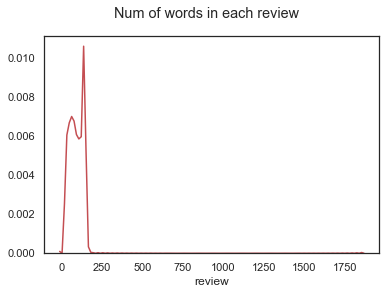

In [24]:
num_words = df['review'].apply(lambda x:len(x.split(' ')))
sns.distplot(num_words, hist = False, kde = True, color=sns.color_palette()[3])
plt.suptitle("Num of words in each review")

## Tokenization, stemming and vectorization

Text(0.5, 0.98, 'Top 20 unigram in review before removing stop words')

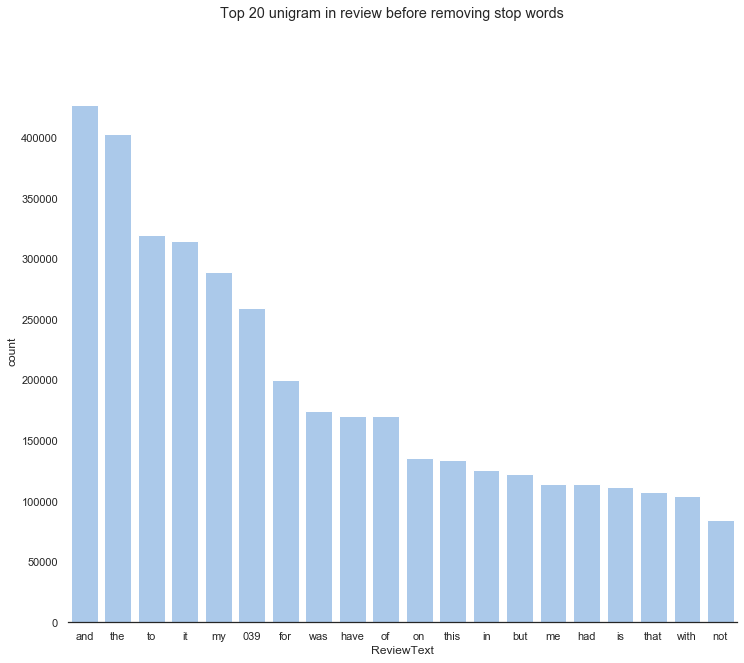

In [25]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df['review'], 20)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])


f, ax = plt.subplots(figsize=(12, 10))
sns.set_color_codes("pastel")
sns.barplot(x="ReviewText", y="count", data=df1, color="b")
sns.despine(left = True)
plt.suptitle("Top 20 unigram in review before removing stop words")

Text(0.5, 0.98, 'Top 20 bigrams in review before removing stop words')

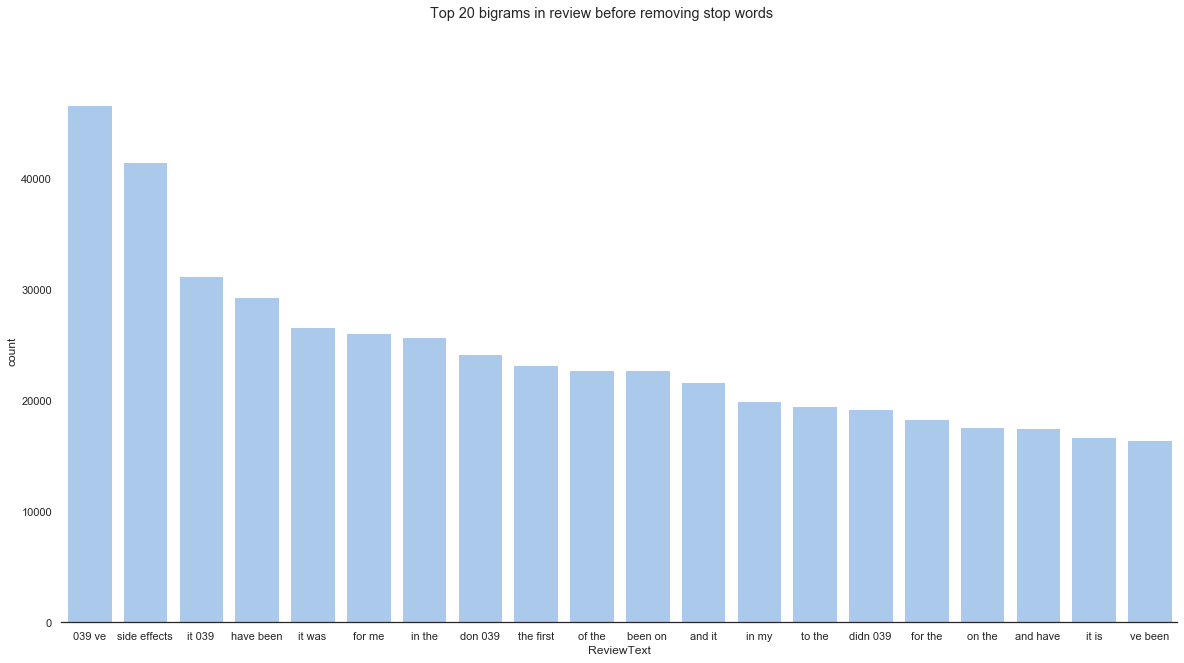

In [26]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['review'], 20)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])


f, ax = plt.subplots(figsize=(20, 10))
sns.set_color_codes("pastel")
sns.barplot(x="ReviewText", y="count", data=df3, color="b")
sns.despine(left = True)
plt.suptitle("Top 20 bigrams in review before removing stop words")

Text(0.5, 0.98, 'Top 20 unigram in review after removing stop words')

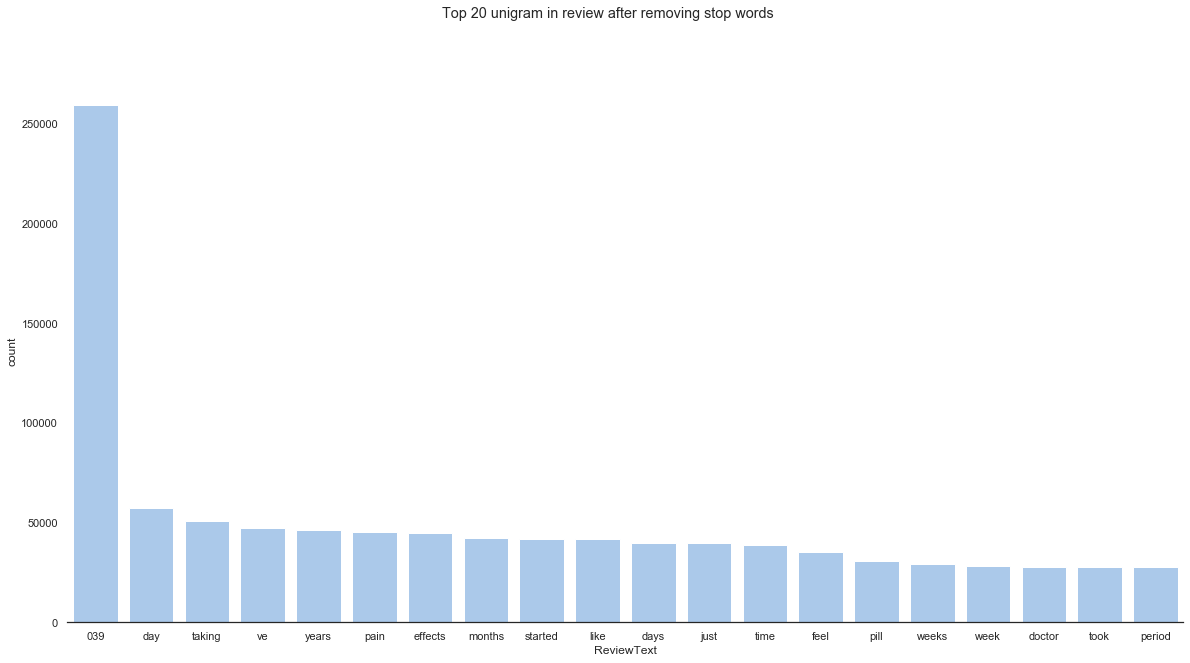

In [27]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df['review'], 20)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])


f, ax = plt.subplots(figsize=(20, 10))
sns.set_color_codes("pastel")
sns.barplot(x="ReviewText", y="count", data=df4, color="b")
sns.despine(left = True)
plt.suptitle("Top 20 unigram in review after removing stop words")

Text(0.5, 0.98, 'Top 20 bigrams in review after removing stop words')

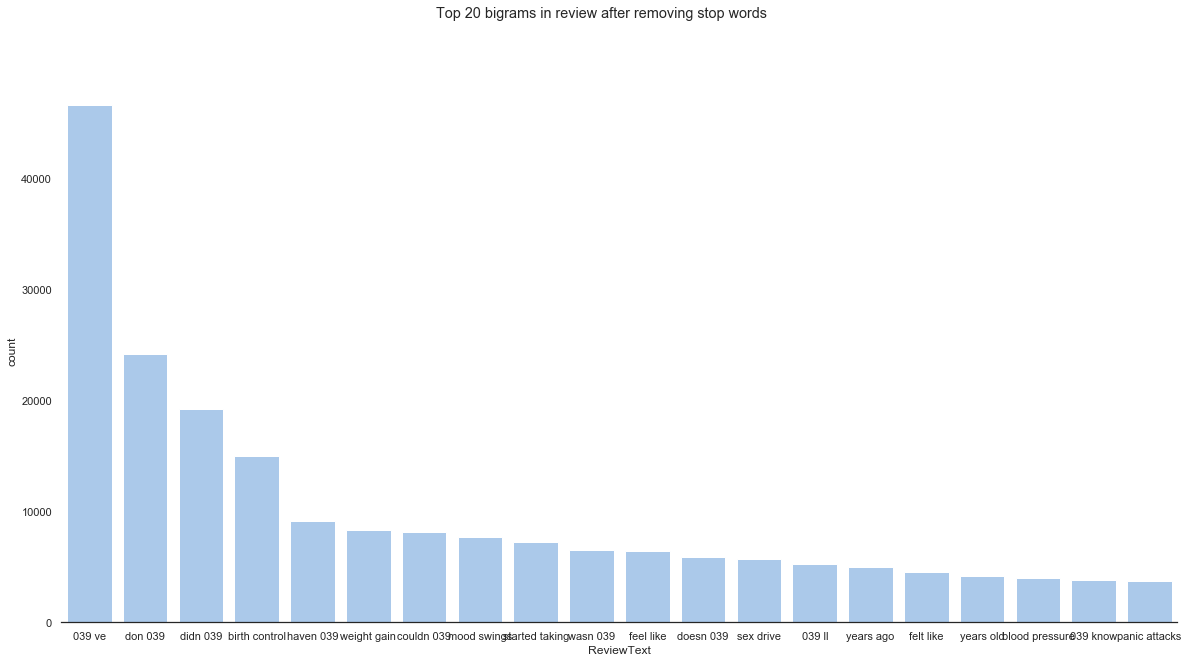

In [28]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['review'], 20)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])


f, ax = plt.subplots(figsize=(20, 10))
sns.set_color_codes("pastel")
sns.barplot(x="ReviewText", y="count", data=df3, color="b")
sns.despine(left = True)
plt.suptitle("Top 20 bigrams in review after removing stop words")

In [31]:
#!pip install spacy
import spacy
nlp = spacy.load("en_core_web_sm")

In [32]:
#!pip install pycontractions
from pycontractions import Contractions
cont = Contractions(api_key="glove-twitter-100")

In [34]:
import re
def sent_expander(sentence):
    sentence = re.sub("&#039;","'",sentence)
    sentence = list(cont.expand_texts([sentence],precise = True))[0]
    return sentence
df.review.apply(lambda x: sent_expander(x))

0         "It has no side effect, I take it in combinati...
1         "My son is halfway through his fourth week of ...
2         "I used to take another oral contraceptive, wh...
3         "This is my first time using any form of birth...
4         "Suboxone has completely turned my life around...
                                ...                        
160393    "I wrote my first report in Mid-October of 201...
160394    "I was given this in IV before surgey. I immed...
160395    "Limited improvement after 4 months, developed...
160396    "I have been on thyroid medication 49 years, I...
160397    "I have had chronic constipation all my adult ...
Name: review, Length: 159498, dtype: object

In [36]:
df.to_csv("updated_drug_train.csv",index = False)

In [2]:
df = pd.read_csv("updated_drug_train.csv")
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
def spacy_tokenizer(sentence):
    tokens =[]
    sentence = nlp(sentence)
    for s in sentence:
        lemma = nlp.vocab[s.text]
        if lemma.is_stop == False:
            tokens.append(s)
    return tokens

In [3]:
df.loc[df['rating'] <= 5, 'senti_new'] = 'Negative'
df.loc[df['rating'] >= 8, 'senti_new'] = 'Positive'
df.loc[(df['rating'] > 5) & (df['rating'] <= 7), 'senti_new'] = 'Neutral'
X = df['review']
y = df['senti_new']

(array([96411.,     0.,     0.,     0.,     0., 47495.,     0.,     0.,
            0., 15592.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

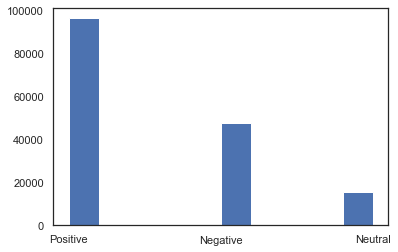

In [197]:
plt.hist(df['senti_new'])

In [8]:
# Split the data into training, testing and validation 
from sklearn.model_selection import train_test_split

X_train, X_validation_test, y_train,y_validation_test = train_test_split(X,y,train_size = 0.6)

X_validation, X_test, y_validation,y_test = train_test_split(X_validation_test,y_validation_test,train_size = 0.5 )

Analysis of naive bayes and SVM using spacy tokenizer

In [155]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


#Unigram Vectorizer 

#Count Vectorizer 
unigram_count_vectorizer = CountVectorizer(encoding='latin-1', binary=False, tokenizer = spacy_tokenizer)

#Tfidf Vectorizer 
unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, tokenizer = spacy_tokenizer)


In [12]:
#Define Algorithms 
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC

mnb_clf = MultinomialNB()
bnb_clf = BernoulliNB()
svm = LinearSVC(C=0.1)

In [157]:
#unigram 

X_train_unigram_count_vec = unigram_count_vectorizer.fit_transform(X_train)
X_train_unigram_tfidf_vec = unigram_tfidf_vectorizer.fit_transform(X_train)

In [158]:
X_validate_unigram_count_vec = unigram_count_vectorizer.transform(X_validation)
X_validate_unigram_tfidf_vec = unigram_tfidf_vectorizer.transform(X_validation)

In [230]:
mnb_unigram_count = mnb_clf.fit(X_train_unigram_count_vec,y_train)
print(mnb_unigram_count.score(X_validate_unigram_count_vec, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = mnb_unigram_count.predict(X_validate_unigram_count_vec)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print(cm)

0.6018808777429467
[[19200     0     0]
 [ 9500     0     0]
 [ 3200     0     0]]


In [229]:
mnb_unigram_tfidf = mnb_clf.fit(X_train_unigram_tfidf_vec,y_train)
print(mnb_unigram_tfidf.score(X_validate_unigram_tfidf_vec, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = mnb_unigram_count.predict(X_validate_unigram_count_vec)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print(cm)

0.6018808777429467
[[19200     0     0]
 [ 9500     0     0]
 [ 3200     0     0]]


In [228]:
svm_unigram_tfidf = svm.fit(X_train_unigram_tfidf_vec,y_train)
print(svm_unigram_tfidf.score(X_validate_unigram_tfidf_vec, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = svm_unigram_tfidf.predict(X_validate_unigram_tfidf_vec)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print(cm)

0.6018808777429467
[[19200     0     0]
 [ 9500     0     0]
 [ 3200     0     0]]


Analysis of code using normal tokenizer 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
unigram_tfidf_vectorizer1 = TfidfVectorizer(encoding='latin-1', use_idf=True, stop_words = 'english',min_df = 10)
unigram_count_vectorizer1 = CountVectorizer(encoding='latin-1', stop_words = 'english',min_df = 10)

In [13]:
X_train_unigram_tfidf_vec1 = unigram_tfidf_vectorizer1.fit_transform(X_train)
X_validate_unigram_tfidf_vec1 = unigram_tfidf_vectorizer1.transform(X_validation)

X_train_unigram_count_vec1 = unigram_count_vectorizer1.fit_transform(X_train)
X_validate_unigram_count_vec1 = unigram_count_vectorizer1.transform(X_validation)

In [378]:
mnb_model = mnb_clf.fit(X_train_unigram_tfidf_vec1, y_train)

print(mnb_model.score(X_validate_unigram_tfidf_vec1, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = mnb_model.predict(X_validate_unigram_tfidf_vec1)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)


from sklearn.metrics import classification_report
target_names = ['Positive','Negative','Neutral']
print(classification_report(y_validation, y_prediction, target_names=target_names))

0.7171786833855799

 [[18400   883     0]
 [ 4951  4478     0]
 [ 2612   576     0]]


/Users/harshita/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    Positive       0.75      0.47      0.58      9429
    Negative       0.00      0.00      0.00      3188
     Neutral       0.71      0.95      0.81     19283

    accuracy                           0.72     31900
   macro avg       0.49      0.48      0.47     31900
weighted avg       0.65      0.72      0.66     31900



In [394]:
mnb_model = mnb_clf.fit(X_train_unigram_count_vec1, y_train)

print(mnb_model.score(X_validate_unigram_count_vec1, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = mnb_model.predict(X_validate_unigram_count_vec1)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)


from sklearn.metrics import classification_report
target_names = ['Positive','Negative','Neutral']
print(classification_report(y_validation, y_prediction, target_names=target_names))

0.6981818181818182

 [[15256  2682  1345]
 [ 2396  6402   631]
 [ 1553  1021   614]]
              precision    recall  f1-score   support

    Positive       0.63      0.68      0.66      9429
    Negative       0.24      0.19      0.21      3188
     Neutral       0.79      0.79      0.79     19283

    accuracy                           0.70     31900
   macro avg       0.55      0.55      0.55     31900
weighted avg       0.69      0.70      0.69     31900



In [10]:
unigram_count_vectorizer2 = CountVectorizer(encoding='latin-1', stop_words = 'english',min_df = 10, binary=True)
X_train_unigram_count_vec_bnb = unigram_count_vectorizer2.fit_transform(X_train)
X_validate_unigram_count_bnb = unigram_count_vectorizer2.transform(X_validation)

In [380]:
bnb_model = bnb_clf.fit(X_train_unigram_count_vec_bnb, y_train)

print(bnb_model.score(X_validate_unigram_count_bnb, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = bnb_model.predict(X_validate_unigram_count_bnb)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)


from sklearn.metrics import classification_report
target_names = ['Positive','Negative','Neutral']
print(classification_report(y_validation, y_prediction, target_names=target_names))

0.7047962382445141

 [[15252  2547  1484]
 [ 2216  6549   664]
 [ 1512   994   682]]
              precision    recall  f1-score   support

    Positive       0.65      0.69      0.67      9429
    Negative       0.24      0.21      0.23      3188
     Neutral       0.80      0.79      0.80     19283

    accuracy                           0.70     31900
   macro avg       0.56      0.57      0.56     31900
weighted avg       0.70      0.70      0.70     31900



0.7656426332288401

 [[17728  1517    11]
 [ 2870  6679     9]
 [ 2109   960    17]]
              precision    recall  f1-score   support

    Positive       0.73      0.70      0.71      9558
    Negative       0.46      0.01      0.01      3086
     Neutral       0.78      0.92      0.84     19256

    accuracy                           0.77     31900
   macro avg       0.66      0.54      0.52     31900
weighted avg       0.73      0.77      0.72     31900



10745

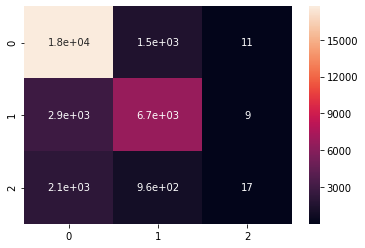

In [22]:
svm.fit(X_train_unigram_tfidf_vec1, y_train)

print(svm.score(X_validate_unigram_tfidf_vec1, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = svm.predict(X_validate_unigram_tfidf_vec1)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)

sns.heatmap(cm, annot= True)

from sklearn.metrics import classification_report
target_names = ['Positive','Negative','Neutral']
print(classification_report(y_validation, y_prediction, target_names=target_names))

len(unigram_tfidf_vectorizer1.get_feature_names())

/Users/harshita/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.760282131661442

 [[17295  1769   219]
 [ 2577  6709   143]
 [ 1954   985   249]]


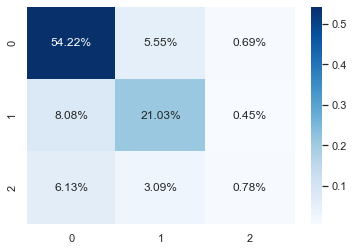

              precision    recall  f1-score   support

    Positive       0.71      0.71      0.71      9429
    Negative       0.41      0.08      0.13      3188
     Neutral       0.79      0.90      0.84     19283

    accuracy                           0.76     31900
   macro avg       0.64      0.56      0.56     31900
weighted avg       0.73      0.76      0.73     31900



In [395]:
svm.fit(X_train_unigram_count_vec1, y_train)

print(svm.score(X_validate_unigram_count_vec1, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = svm.predict(X_validate_unigram_count_vec1)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)

sns.heatmap(cm/np.sum(cm),annot = True, fmt='.2%', cmap="Blues")
b, t = plt.ylim() 
b += 0.5 # 
t -= 0.5 # 
plt.ylim(b, t) 
plt.show() 

from sklearn.metrics import classification_report
target_names = ['Positive','Negative','Neutral']
print(classification_report(y_validation, y_prediction, target_names=target_names))

In [23]:
unigram_tfidf_vectorizer2 = TfidfVectorizer(encoding='latin-1', use_idf=True,min_df =1)
X_train_unigram_tfidf_vec2 = unigram_tfidf_vectorizer2.fit_transform(X_train)
X_validate_unigram_tfidf_vec2 = unigram_tfidf_vectorizer2.transform(X_validation)

0.778307210031348

 [[17825  1418    13]
 [ 2570  6975    13]
 [ 2109   949    28]]
              precision    recall  f1-score   support

    Positive       0.75      0.73      0.74      9558
    Negative       0.52      0.01      0.02      3086
     Neutral       0.79      0.93      0.85     19256

    accuracy                           0.78     31900
   macro avg       0.69      0.55      0.54     31900
weighted avg       0.75      0.78      0.74     31900



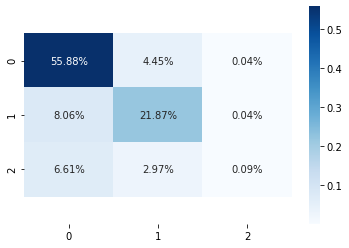

41931

In [26]:
import numpy as np
svm.fit(X_train_unigram_tfidf_vec2, y_train)

print(svm.score(X_validate_unigram_tfidf_vec2, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = svm.predict(X_validate_unigram_tfidf_vec2)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)


from sklearn.metrics import classification_report
target_names = ['Positive','Negative','Neutral']
print(classification_report(y_validation, y_prediction, target_names=target_names))

sns.heatmap(cm/np.sum(cm),annot = True, fmt='.2%', cmap="Blues")
b, t = plt.ylim() 
b += 0.5 # 
t -= 0.5 # 
plt.ylim(b, t) 
plt.show() 
len(unigram_tfidf_vectorizer2.get_feature_names())

In [27]:
#bigram
bigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True,min_df =1,ngram_range=(1,2))
X_train_bigram_tfidf_vec = bigram_tfidf_vectorizer.fit_transform(X_train)
X_validate_bigram_tfidf_vec = bigram_tfidf_vectorizer.transform(X_validation)

0.8106269592476489

 [[18346   902     8]
 [ 2121  7432     5]
 [ 2120   885    81]]
              precision    recall  f1-score   support

    Positive       0.81      0.78      0.79      9558
    Negative       0.86      0.03      0.05      3086
     Neutral       0.81      0.95      0.88     19256

    accuracy                           0.81     31900
   macro avg       0.83      0.59      0.57     31900
weighted avg       0.82      0.81      0.77     31900



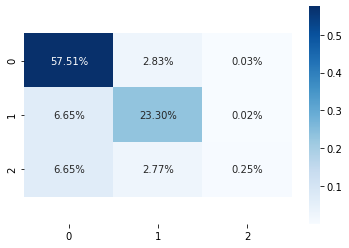

934345

In [28]:
svm.fit(X_train_bigram_tfidf_vec, y_train)

print(svm.score(X_validate_bigram_tfidf_vec, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = svm.predict(X_validate_bigram_tfidf_vec)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)


from sklearn.metrics import classification_report
target_names = ['Positive','Negative','Neutral']
print(classification_report(y_validation, y_prediction, target_names=target_names))

sns.heatmap(cm/np.sum(cm),annot = True, fmt='.2%', cmap="Blues")
b, t = plt.ylim() 
b += 0.5 # 
t -= 0.5 # 
plt.ylim(b, t) 
plt.show() 
len(bigram_tfidf_vectorizer.get_feature_names())

In [29]:
#trigram
trigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True,min_df =1,ngram_range=(1,3))
X_train_trigram_tfidf_vec = trigram_tfidf_vectorizer.fit_transform(X_train)
X_validate_trigram_tfidf_vec = trigram_tfidf_vectorizer.transform(X_validation)

0.8089655172413793

 [[18437   815     4]
 [ 2239  7317     2]
 [ 2217   817    52]]
              precision    recall  f1-score   support

    Positive       0.82      0.77      0.79      9558
    Negative       0.90      0.02      0.03      3086
     Neutral       0.81      0.96      0.87     19256

    accuracy                           0.81     31900
   macro avg       0.84      0.58      0.57     31900
weighted avg       0.82      0.81      0.77     31900



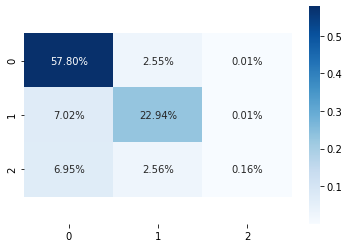

3891377

In [30]:
#Validate the results 

svm.fit(X_train_trigram_tfidf_vec, y_train)

print(svm.score(X_validate_trigram_tfidf_vec, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = svm.predict(X_validate_trigram_tfidf_vec)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)


from sklearn.metrics import classification_report
target_names = ['Positive','Negative','Neutral']
print(classification_report(y_validation, y_prediction, target_names=target_names))

sns.heatmap(cm/np.sum(cm),annot = True, fmt='.2%', cmap="Blues")
b, t = plt.ylim() 
b += 0.5 # 
t -= 0.5 # 
plt.ylim(b, t) 
plt.show() 
len(trigram_tfidf_vectorizer.get_feature_names())

In [31]:
#bigram
bigram_tfidf_vectorizer1 = TfidfVectorizer(encoding='latin-1', use_idf=True,min_df =1,ngram_range=(3,3))
X_train_bigram_tfidf_vec1 = bigram_tfidf_vectorizer1.fit_transform(X_train)
X_validate_bigram_tfidf_vec1 = bigram_tfidf_vectorizer1.transform(X_validation)

0.7639184952978056

 [[18778   478     0]
 [ 3968  5590     0]
 [ 2626   459     1]]
              precision    recall  f1-score   support

    Positive       0.86      0.58      0.70      9558
    Negative       1.00      0.00      0.00      3086
     Neutral       0.74      0.98      0.84     19256

    accuracy                           0.76     31900
   macro avg       0.87      0.52      0.51     31900
weighted avg       0.80      0.76      0.72     31900



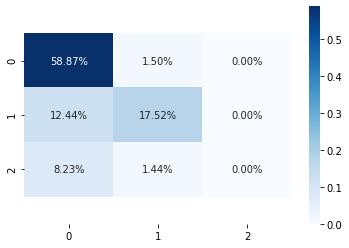

2957032

In [32]:
svm.fit(X_train_bigram_tfidf_vec1, y_train)

print(svm.score(X_validate_bigram_tfidf_vec1, y_validation))

from sklearn.metrics import confusion_matrix
y_prediction = svm.predict(X_validate_bigram_tfidf_vec1)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)


from sklearn.metrics import classification_report
target_names = ['Positive','Negative','Neutral']
print(classification_report(y_validation, y_prediction, target_names=target_names))

sns.heatmap(cm/np.sum(cm),annot = True, fmt='.2%', cmap="Blues")
b, t = plt.ylim() 
b += 0.5 # 
t -= 0.5 # 
plt.ylim(b, t) 
plt.show() 
len(bigram_tfidf_vectorizer1.get_feature_names())

In [391]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 10, 100,1000,0.01]}
grid = GridSearchCV(LinearSVC(), param_grid)
grid.fit(X_train_bigram_tfidf_vec, y_train)
print(grid.best_params_) 

/Users/harshita/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/harshita/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 1}


In [392]:
grid_predictions = grid.predict(X_validate_bigram_tfidf_vec) 
  
# print classification report 
print(classification_report(y_validation, grid_predictions)) 


              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85      9429
     Neutral       0.81      0.36      0.50      3188
    Positive       0.88      0.95      0.91     19283

    accuracy                           0.86     31900
   macro avg       0.84      0.72      0.75     31900
weighted avg       0.86      0.86      0.85     31900




 [[18262   857   164]
 [ 1254  8067   108]
 [ 1340   700  1148]]


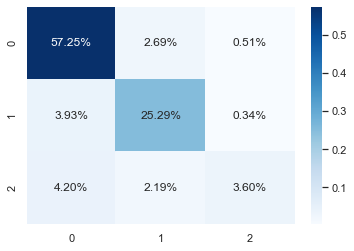

In [403]:
#!pip install matplotlib==3.1.2
import numpy as np
svm_best = LinearSVC(C=1)
svm_best.fit(X_train_bigram_tfidf_vec, y_train)

y_prediction = svm_best.predict(X_validate_bigram_tfidf_vec)
cm=confusion_matrix(y_validation, y_prediction, labels=['Positive','Negative','Neutral'])
print('\n',cm)

sns.heatmap(cm/np.sum(cm),annot = True, fmt='.2%', cmap="Blues")
b, t = plt.ylim() 
b += 0.5 # 
t -= 0.5 # 
plt.ylim(b, t) 
plt.show() 

In [406]:
feature_ranks = sorted(zip(svm_clf.coef_[0], bigram_tfidf_vectorizer.get_feature_names()))

negative_10 = feature_ranks[-10:]
print("negative words")
for i in range(0, len(negative_10)):
    print(negative_10[i])
print()


positive_10 = feature_ranks[:10]
print("Positive words")
for i in range(0, len(positive_10)):
    print(positive_10[i])
print()

negative words
(0.13507381016950318, 'and sprycel')
(0.13507381016950318, 'blowing made')
(0.13507381016950318, 'delvering acne')
(0.1350739388396289, 'always changed')
(0.1350739388396289, 'awful tired')
(0.1350739388396289, 'choice whether')
(0.1654301442803445, '80mg three')
(0.1654301442803445, 'finesteride')
(0.16543055364916479, 'and degrading')
(0.16543055364916479, 'fortunately mine')

Positive words
(-0.07027150294293193, 'advised we')
(-0.07027150294293193, 'eventually did')
(-0.0702714983914659, 'also becoming')
(-0.0702714983914659, 'be hooked')
(-0.07027099379075394, '27 it')
(-0.07027099379075394, 'essentially instant')
(-0.05737750635460864, 'and strongly')
(-0.05737750635460864, 'bar really')
(-0.05737750635460864, 'blowing things')
(-0.05737717966796421, 'and ra')

